In this assignment, you are going to implement Algorithm 8.1 (Factorization algorithm for multiple-view reconstruction) from textbook.

In [36]:
import json
import math
import os
import os.path as osp
import random
import sys
from glob import glob

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
from utils.utils import *

First, we load the SceneCity Urban 3D (SU3) dataset from the disk.  This synthetic dataset contains the ground truth junctions and lines for each image and their correspondance among images.  The following code loads the dataset and display the lines and junctions.  The same junction and line instances in difference images have the same value in `lineidx` and `juncidx`, and therefore they will have the same color in the following demo images.

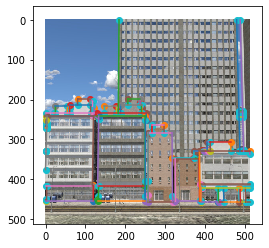

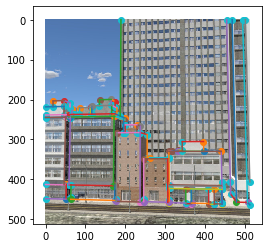

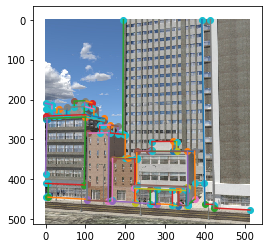

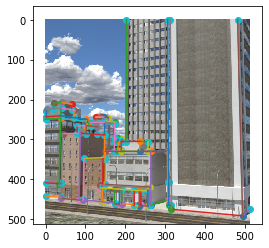

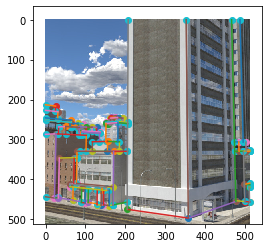

In [37]:
N_IMAGE = 5

color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fs = glob("data/00/*_0.jpg")
fs.sort()
lines = []
juncs = []
lineids = []
juncids = []
images = []
Rt = [] # world to camera matrix (for verification purpose only. DO NOT USE THIS MATRIX IN YOUR IMPLEMENTATION)
K = None # camera to pixel matrix

for fjpg in fs[:N_IMAGE]:
    fjs = fjpg.replace(".jpg", "_label.json")
    js = json.load(open(fjs))

    line = js["line"]
    lineidx = js["lineidx"]
    junc = np.array(js["junction"])
    juncidx = js["junindex"]
    K = js["K"]
    Rt.append(np.array(js["RT"]))

    junc[:, 1] *= -1
    junc *= 256
    junc += 256

    lines.append(line)
    juncs.append(junc)
    lineids.append(lineidx)
    juncids.append(juncidx)

    I = cv2.imread(fjpg)[..., ::-1]
    plt.figure()
    plt.imshow(I)
    images.append(I)
    for ln, idx in zip(line, lineidx):
        idx += len(color)
        plt.plot(
            [junc[ln[0], 0], junc[ln[1], 0]],
            [junc[ln[0], 1], junc[ln[1], 1]],
            c=color[idx % len(color)],
        )
    for jun, idx in zip(junc, juncidx):
        idx += len(color)
        plt.scatter(jun[0], jun[1], c=color[idx % len(color)])

# convert projection matrix (OpenGL format) to OpenCV format to avoid confusion
# the unit of the projection matrix is pixel now (OpenCV format).
# If you are still confusing, you may want to read
#     http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT9/node2.html
#     https://github.com/vvvv/VL.OpenCV/wiki/Coordinate-system-conversions-between-OpenCV,-DirectX-and-vvvv
K = np.array([[K[0][0] * 256, 0            , 256], 
              [0            , K[1][1] * 256, 256], 
              [0            , 0            , 1]])

Next, we need to extract the common junctions from multiple images and put them in a numpy array.  **You need to implement this function.**  You can refer to the demo code that visualize the dataset. Notice that T-junctions are not real junctions in 3D (their `juncidx` is -1, i.e., cyan dots in the demo images) so they should not be included.

25 common junction extracted from 5 images


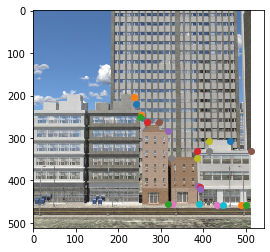

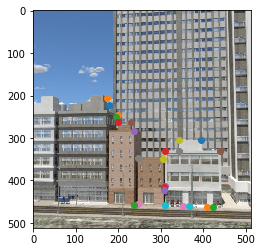

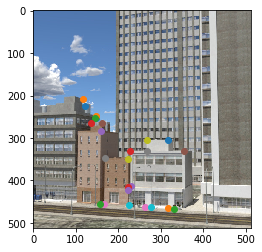

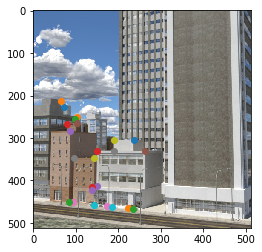

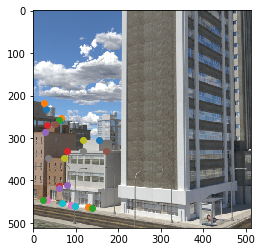

In [38]:
def extract_corresponding_junction(juncs, juncids):
    juc = set(juncids[0])
    for i in range(4):
        juc &= set(juncids[i+1])
    juc = list(juc)
    juc = juc[0:-1]
    xs = np.zeros([len(juncs), len(juc) ,2])
    for i in range(5):
        for j in range(len(juc)):
            number = juncids[i].index(juc[j])
            xs[i][j] = juncs[i][number]
#     print(xs)
    return xs 

xs = extract_corresponding_junction(juncs, juncids)
print(xs.shape[1], "common junction extracted from", len(juncs), "images")
# visualize common junctions
color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for im_i, I in enumerate(images):
    plt.imshow(I)
    for pt_i, (y, x) in enumerate(xs[im_i]): 
        plt.scatter(y, x, c=color[pt_i % len(color)])
    plt.show()

Here is the most intereseting part. **Implement Algorithm 8.1 (Factorization algorithm for multiple-view reconstruction) from the textbook.**

In [39]:
def factorization_algorithm(xs, K):
    """Factorization algorithm for multiple-view reconstruction.

    Args:
      xs: coordinate of junctions of shape [N_IMAGES, N_POINTS, 2]
      K: camera projection matrix (OpenCV format)

    Returns:
      alpha: inversion of depth of each junction in the reference view with shape [N_POINTS]
      Rs: rotation matrix w.r.t the first view of other view with shape [N_IMAGES, 3, 3]
      Ts: translation vector w.r.t the first view of other view with shape [N_IMAGES, 3]
    """
    N_IMAGES, N_POINTS = xs.shape[0], xs.shape[1]
    views = np.zeros((N_IMAGES, N_POINTS, 3))
    for i in range(N_IMAGES):
        views[i] = img2world(xs[i], K)
    view1, view2 = views[0], views[1]
    eps = 1e-4
    num_iters = 1
    iter_check = 1
    
    """
    Algorithm 8.1
    """
    # 1. Initialization k = 0
    k = 0
    # 1.(a) Compute [R2, T2] using the 8 point algorithm.
    R_2, T_2 = eight_point_algorithm(xs, K)
    # 1.(b) Compute alpha from (8.43)
    alpha = find_alpha(view1, view2, R_2, T_2)
    # 1.(c) normalize alpha with respect to first value
    alpha = alpha / alpha[0]
   
    # 2 Compute [Ri, Ti] from (8.40) 
    x_proj = np.zeros_like(views)
    projection_matrices = {i: (None, None) for i in range(2, N_IMAGES + 1)}

    while np.linalg.norm(x_proj - views) ** 2 > eps and k < num_iters:
        for i in range(2, N_IMAGES + 1):
            # 2,3 
            R_i, T_i = estimate_R_T(views, i, alpha)
            projection_matrices[i] = R_i, T_i
        # 4 Compute the new alpha and normalize
        alpha = update_alphas(views, projection_matrices)
        alpha_1 = alpha[0]
        # Update translation
        for _, T_i in projection_matrices.values():
            T_i *= alpha[0]
        alpha /= alpha[0]
        # Reprojection and find the reprojecion error
        x_proj = compute_reprojections(alpha, projection_matrices, views[0])
        x_proj = np.concatenate((views[0][np.newaxis, :], x_proj), axis=0)
        error = np.linalg.norm(x_proj - views)
        if k % iter_check == 0:
            print("Reprojection error:",error)
            print(".Tteration time:", k)
        k += 1

    R_s, T_s = np.zeros((N_IMAGES, 3, 3)), np.zeros((N_IMAGES, 3))
    for i in range(1, N_IMAGES + 1):
        if i == 1:
            R_s[i - 1] = np.eye(3)
        else:
            R_i, T_i = projection_matrices[i]
            R_s[i - 1] = R_i
            T_s[i - 1] = T_i.T

    return alpha, R_s, T_s 
alpha, Rs, Ts = factorization_algorithm(xs, K)

[[ 0.9999049  -0.01374778 -0.00108692]
 [ 0.01374778  0.98748099  0.1571378 ]
 [-0.00108698 -0.1571378   0.98757609]] [[ 0.00689544]
 [-0.99686536]
 [ 0.07881563]]
[[-1.40203116e-01 -1.16588187e-01 -1.65069506e-01 ... -2.15854407e-02
  -8.39615855e-02  1.00571083e-02]
 [-1.17603297e-01  1.38667115e-01  1.82567478e-01 ... -1.76683904e-01
   3.14632127e-02  3.47619473e-02]
 [-9.19910761e-03  9.39242984e-03  1.23062681e-02 ... -2.34816281e-02
  -1.01497969e-02  5.56825877e-03]
 ...
 [-1.54650946e-01 -1.33213914e-01  3.63366335e-02 ...  8.76528578e-01
   6.32183332e-02  2.15642418e-02]
 [-1.32643672e-01  1.59738981e-01 -1.12996049e-01 ...  3.87244061e-02
   8.15755097e-01  4.11661929e-03]
 [ 4.10266700e-02  1.72088986e-02 -1.00126890e-04 ...  2.31850503e-02
  -9.91100380e-04  9.95230801e-01]] 

[[-1.40203116e-01 -1.16588187e-01 -1.65069506e-01 -2.14684228e-01
   5.82030161e-02 -2.27929452e-02 -2.62623074e-01 -2.62432846e-01
   1.51555010e-01 -2.69217812e-02 -1.43758494e-01  5.37488169e-02]

We provide some sanity checks. Execute them to verify you result.

In [40]:
# Verification
for i in range(N_IMAGE):
    # R should be a rotation matrix
    assert np.allclose(Rs[i] @ Rs[i].T, np.eye(3), atol=1e-4), i

    # compare with ground truth
    Rt_gt = Rt[i] @ np.linalg.inv(Rt[0])
    R_gt = Rt_gt[:3, :3]
    T_gt = Rt_gt[:3, 3]

Finally, verify the correctness of your algorithm by reprojection the junctions from other views to the reference view and **visualize them using matplotlib**.

(25, 2)


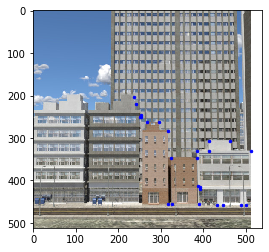

(25, 2)


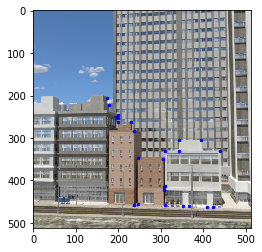

(25, 2)


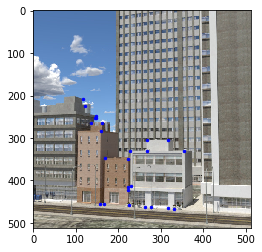

(25, 2)


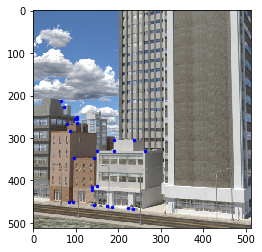

(25, 2)


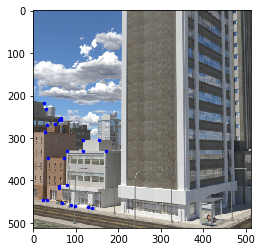

In [44]:
def visualize_reprojection(I, x, alpha, R, T, K):
    """Verify the algorithm by reproject x using R, T, and K to I. Visualization using matplotlib.
    
    Args:
      I: image (new view)
      x: coordinate of junctions in reference view
      alpha: inversion of depth of each junction in the first view with shape [N_POINTS]
      R: rotation with respect to the reference
      T: translation with respect to the reference
      K: camera projection matrix 
    """
    plt.imshow(I)
    # YOUR CODE to draw the reprojected junctions
    xs_world = img2world(x, K)

    pview1 = []
    for i, x0 in enumerate(xs_world):
        proj = R @ x0 / alpha[i] + T
        pview1.append(proj)
        
    pview1 = np.squeeze(pview1)
    pcam1 = world2img(pview1, K)
    print(pcam1.shape)
    plt.scatter(pcam1[:, 0], pcam1[:, 1], c='blue', s=6)
    plt.show()

for i in range(N_IMAGE):
    visualize_reprojection(images[i], xs[0], alpha, Rs[i], Ts[i], K)

*Bonus Question (20%):* Modify the algorithm 8.1 so that it is able to handle the line in the SceneCity dataset. **Write down the pseudo-code.**


1: Keep the list of all lines as a set of tuples (p1, p2), which means to draw a line between all $p_1$ and $p_2$.

2: Use algorithm 8.1 to calculate alpha, R_s, T_s.

3: Calculate the reprojection point of each image.

4: For each line in our line list (p1, p2): draw the line between $ \Pi_ {i} (p_1) $ and $ \Pi_ {i} (p_2) $,where  i = 2, ..., m. That is the reprojection of each line.

*Bonus Question (100%):* Implement your algorithm and verify its correctness.